### IMDB Subwords - Single layer BiLSTM

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

In [ ]:
import pandas as pd
import numpy as np
import csv
import random
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete4D7UAG/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete4D7UAG/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete4D7UAG/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'train': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>}

In [ ]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [ ]:
train_data, test_data = dataset['train'], dataset['test']

In [ ]:
tokenizer = info.features['text'].encoder

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_data = train_data.shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_data))
test_data = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [ ]:
embedding_dim = 64
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=embedding_dim),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 15
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/15
391/391 [==============================] - 169s 409ms/step - loss: 0.5946 - accuracy: 0.6730 - val_loss: 0.4021 - val_accuracy: 0.8374
Epoch 2/15
391/391 [==============================] - 157s 400ms/step - loss: 0.3297 - accuracy: 0.8636 - val_loss: 0.3932 - val_accuracy: 0.8224
Epoch 3/15
391/391 [==============================] - 158s 401ms/step - loss: 0.2628 - accuracy: 0.8973 - val_loss: 0.3545 - val_accuracy: 0.8552
Epoch 4/15
391/391 [==============================] - 157s 400ms/step - loss: 0.2399 - accuracy: 0.9075 - val_loss: 0.3746 - val_accuracy: 0.8654
Epoch 5/15
391/391 [==============================] - 159s 405ms/step - loss: 0.2004 - accuracy: 0.9242 - val_loss: 0.4240 - val_accuracy: 0.8502
Epoch 6/15
391/391 [==============================] - 159s 404ms/step - loss: 0.1820 - accuracy: 0.9311 - val_loss: 0.3764 - val_accuracy: 0.8514
Epoch 7/15
391/391 [==============================] - 160s 406ms/step - loss: 0.1507 - accuracy: 0.9449 - val_loss: 0.4750 -

<Figure size 432x288 with 0 Axes>

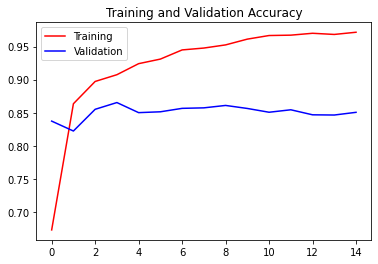

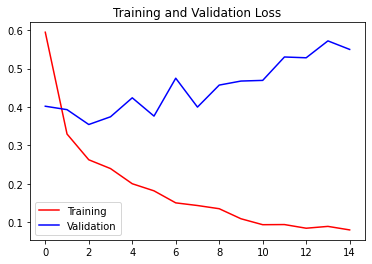

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

### IMDB Subwords - Multi layer BiLSTM

In [ ]:
embedding_dim = 64
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=embedding_dim),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=5)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=5, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 15
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/15
391/391 [==============================] - 321s 801ms/step - loss: 0.5923 - accuracy: 0.6816 - val_loss: 0.4894 - val_accuracy: 0.7767
Epoch 2/15
391/391 [==============================] - 308s 787ms/step - loss: 0.3596 - accuracy: 0.8472 - val_loss: 0.3243 - val_accuracy: 0.8651
Epoch 3/15
391/391 [==============================] - 307s 785ms/step - loss: 0.2566 - accuracy: 0.8983 - val_loss: 0.3280 - val_accuracy: 0.8607
Epoch 4/15
391/391 [==============================] - 307s 784ms/step - loss: 0.2039 - accuracy: 0.9225 - val_loss: 0.3251 - val_accuracy: 0.8744
Epoch 5/15
391/391 [==============================] - 309s 789ms/step - loss: 0.1568 - accuracy: 0.9436 - val_loss: 0.3316 - val_accuracy: 0.8719
Epoch 6/15
391/391 [==============================] - 312s 795ms/step - loss: 0.1262 - accuracy: 0.9556 - val_loss: 0.3535 - val_accuracy: 0.8662
Epoch 7/15
391/391 [==============================] - 309s 788ms/step - loss: 0.0936 - accuracy: 0.9683 - val_loss: 0.4015 -

<Figure size 432x288 with 0 Axes>

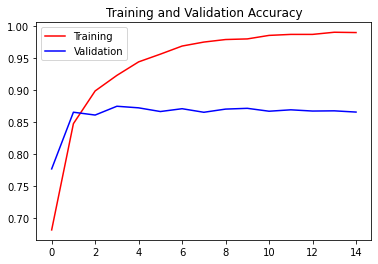

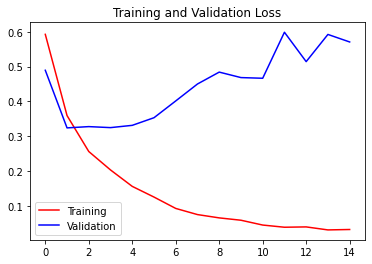

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

### IMDB Subwords - Conv1D

In [ ]:
embedding_dim = 64
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=embedding_dim),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=5)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=5, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 15
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_data,
                    validation_data=test_data,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/15
391/391 [==============================] - 74s 121ms/step - loss: 0.3566 - accuracy: 0.8381 - val_loss: 0.2683 - val_accuracy: 0.8897
Epoch 2/15
391/391 [==============================] - 24s 59ms/step - loss: 0.1901 - accuracy: 0.9292 - val_loss: 0.3010 - val_accuracy: 0.8811
Epoch 3/15
391/391 [==============================] - 20s 50ms/step - loss: 0.1353 - accuracy: 0.9504 - val_loss: 0.3995 - val_accuracy: 0.8551
Epoch 4/15
391/391 [==============================] - 18s 44ms/step - loss: 0.0970 - accuracy: 0.9644 - val_loss: 0.4295 - val_accuracy: 0.8677
Epoch 5/15
391/391 [==============================] - 18s 43ms/step - loss: 0.0644 - accuracy: 0.9780 - val_loss: 0.4879 - val_accuracy: 0.8657
Epoch 6/15
391/391 [==============================] - 17s 42ms/step - loss: 0.0452 - accuracy: 0.9840 - val_loss: 0.6129 - val_accuracy: 0.8600
Epoch 7/15
391/391 [==============================] - 17s 41ms/step - loss: 0.0390 - accuracy: 0.9870 - val_loss: 0.7659 - val_accuracy

<Figure size 432x288 with 0 Axes>

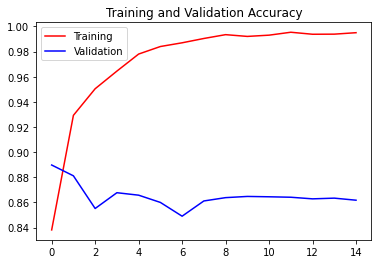

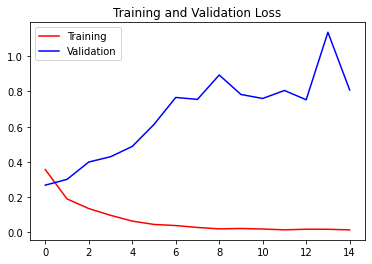

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## IMDB - BiLSTM

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

In [3]:
import pandas as pd
import numpy as np
import csv
import random
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import tensorflow_datasets as tfds

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7REK1Y/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7REK1Y/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7REK1Y/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
imdb

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}

In [6]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [7]:
train_data, test_data = imdb['train'], imdb['test']

In [8]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_data:
    training_sentences.append(str(s.numpy()))         # tensor -> numpy -> extracting sentences 
    training_labels.append(l.numpy())                 # tensor -> numpy -> extracting labels
  
for s, l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

In [9]:
training_sentences[:2]

['b"This was an absolutely terrible movie. Don\'t be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie\'s ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor\'s like Christopher Walken\'s good name. I could barely sit through it."',
 "b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot devel

In [10]:
training_labels[:2]

[0, 0]

In [11]:
len(training_sentences), len(training_labels)

(25000, 25000)

In [12]:
len(testing_sentences), len(testing_labels)

(25000, 25000)

In [13]:
type(training_labels)

list

In [14]:
# when training, labels should be numpy arrays

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [15]:
VOCAB_SIZE = 10000                      # number of unique words in the corpus
EMBED_DIM = 16                          # number of dimensions we wish to embed each word into
MAX_LEN = 120                           # maximum length of document/sentence

TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOKEN = '<OOV>'                     # out of vocab words in test set will be marked OOV

In [16]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [17]:
print(len(training_sequences[0]), len(training_padded[0]))
print(len(training_sequences[1]), len(training_padded[1]))
print(len(training_sequences[10]), len(training_padded[10]))

118 120
113 120
177 120


In [19]:
training_padded.shape

(25000, 120)

In [18]:
print(len(testing_sequences))
print(testing_padded.shape)

25000
(25000, 120)


In [20]:
len(word_index)

86539

In [21]:
training_padded[0]

array([  59,   12,   14,   35,  439,  400,   18,  174,   29,    1,    9,
         33, 1378, 3401,   42,  496,    1,  197,   25,   88,  156,   19,
         12,  211,  340,   29,   70,  248,  213,    9,  486,   62,   70,
         88,  116,   99,   24, 5740,   12, 3317,  657,  777,   12,   18,
          7,   35,  406, 8228,  178, 2477,  426,    2,   92, 1253,  140,
         72,  149,   55,    2,    1, 7525,   72,  229,   70, 2962,   16,
          1, 2880,    1,    1, 1506, 4998,    3,   40, 3947,  119, 1608,
         17, 3401,   14,  163,   19,    4, 1253,  927, 7986,    9,    4,
         18,   13,   14, 4200,    5,  102,  148, 1237,   11,  240,  692,
         13,   44,   25,  101,   39,   12, 7232,    1,   39, 1378,    1,
         52,  409,   11,   99, 1214,  874,  145,   10,    0,    0],
      dtype=int32)

In [22]:
training_labels[:5]

array([0, 0, 0, 1, 1])

In [23]:
NUM_CLASSES = 1

In [37]:
model = Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(6, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [39]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [40]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [41]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=12)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=8, min_lr=0.001, mode='min', verbose=1, factor=0.1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [42]:
EPOCHS = 20
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [43]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/20
782/782 [==============================] - 51s 61ms/step - loss: 0.6722 - accuracy: 0.5624 - val_loss: 0.6110 - val_accuracy: 0.6664 - lr: 0.0100
Epoch 2/20
782/782 [==============================] - 47s 60ms/step - loss: 0.3863 - accuracy: 0.8282 - val_loss: 0.3857 - val_accuracy: 0.8266 - lr: 0.0100
Epoch 3/20
782/782 [==============================] - 47s 60ms/step - loss: 0.2437 - accuracy: 0.9026 - val_loss: 0.4130 - val_accuracy: 0.8203 - lr: 0.0100
Epoch 4/20
782/782 [==============================] - 47s 60ms/step - loss: 0.1574 - accuracy: 0.9414 - val_loss: 0.5190 - val_accuracy: 0.8081 - lr: 0.0100
Epoch 5/20
782/782 [==============================] - 47s 60ms/step - loss: 0.0985 - accuracy: 0.9669 - val_loss: 0.6024 - val_accuracy: 0.8020 - lr: 0.0100
Epoch 6/20
782/782 [==============================] - 47s 60ms/step - loss: 0.0649 - accuracy: 0.9788 - val_loss: 0.7083 - val_accuracy: 0.7992 - lr: 0.0100
Epoch 7/20
782/782 [==============================] - 47s 

<Figure size 432x288 with 0 Axes>

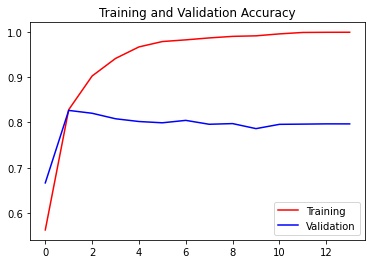

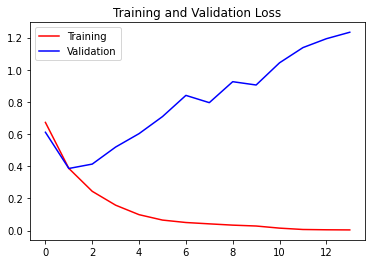

<Figure size 432x288 with 0 Axes>

In [44]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## IMDB - BiGRU

In [45]:
NUM_CLASSES = 1

In [46]:
model = Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.Bidirectional(layers.GRU(32)),
    layers.Dense(6, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [48]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [50]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [49]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=12)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=8, min_lr=0.001, mode='min', verbose=1, factor=0.1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [51]:
EPOCHS = 20
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [52]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/20
782/782 [==============================] - 88s 61ms/step - loss: 0.4675 - accuracy: 0.7622 - val_loss: 0.3649 - val_accuracy: 0.8362 - lr: 0.0100
Epoch 2/20
782/782 [==============================] - 47s 60ms/step - loss: 0.2625 - accuracy: 0.8925 - val_loss: 0.3842 - val_accuracy: 0.8360 - lr: 0.0100
Epoch 3/20
782/782 [==============================] - 47s 60ms/step - loss: 0.1790 - accuracy: 0.9308 - val_loss: 0.4680 - val_accuracy: 0.8209 - lr: 0.0100
Epoch 4/20
782/782 [==============================] - 47s 60ms/step - loss: 0.1149 - accuracy: 0.9580 - val_loss: 0.5009 - val_accuracy: 0.8105 - lr: 0.0100
Epoch 5/20
782/782 [==============================] - 47s 60ms/step - loss: 0.0805 - accuracy: 0.9724 - val_loss: 0.6148 - val_accuracy: 0.8094 - lr: 0.0100
Epoch 6/20
782/782 [==============================] - 47s 60ms/step - loss: 0.0614 - accuracy: 0.9771 - val_loss: 0.7132 - val_accuracy: 0.8067 - lr: 0.0100
Epoch 7/20
782/782 [==============================] - 47s 

<Figure size 432x288 with 0 Axes>

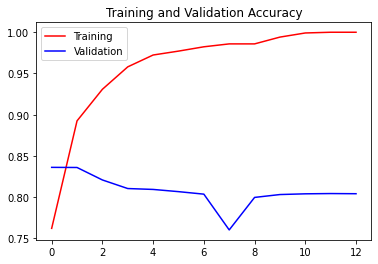

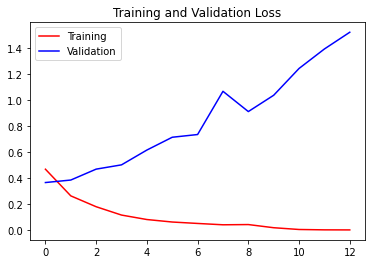

<Figure size 432x288 with 0 Axes>

In [53]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## IMDB - Conv1D

In [54]:
NUM_CLASSES = 1

In [55]:
model = Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(6, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [56]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 6)                 774       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [57]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [58]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [59]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=12)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=8, min_lr=0.001, mode='min', verbose=1, factor=0.1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [60]:
EPOCHS = 20
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [61]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/20
782/782 [==============================] - 35s 11ms/step - loss: 0.4311 - accuracy: 0.8087 - val_loss: 0.3812 - val_accuracy: 0.8311 - lr: 0.0100
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 0.2741 - accuracy: 0.8923 - val_loss: 0.4014 - val_accuracy: 0.8211 - lr: 0.0100
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 0.2017 - accuracy: 0.9252 - val_loss: 0.4660 - val_accuracy: 0.8176 - lr: 0.0100
Epoch 4/20
782/782 [==============================] - 9s 11ms/step - loss: 0.1408 - accuracy: 0.9522 - val_loss: 0.5654 - val_accuracy: 0.8068 - lr: 0.0100
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 0.0981 - accuracy: 0.9691 - val_loss: 0.6815 - val_accuracy: 0.8069 - lr: 0.0100
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 0.0763 - accuracy: 0.9776 - val_loss: 0.7616 - val_accuracy: 0.8005 - lr: 0.0100
Epoch 7/20
782/782 [==============================] - 8s 11ms/s

<Figure size 432x288 with 0 Axes>

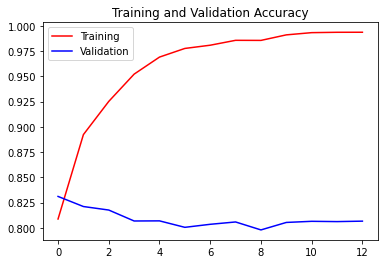

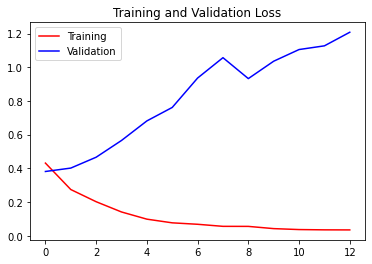

<Figure size 432x288 with 0 Axes>

In [62]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Sarcasm - BiLSTM

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

In [3]:
import pandas as pd
import numpy as np
import csv
import random
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /content/sarcasm.json

--2021-11-14 04:47:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/content/sarcasm.json’

/content/sarcasm.js 100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2021-11-14 04:47:32 (140 MB/s) - ‘/content/sarcasm.json’ saved [5643545/5643545]



In [5]:
with open("/content/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [6]:
datastore[:5]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [7]:
len(datastore)

26709

In [8]:
sentences[:2]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse"]

In [9]:
labels[:2]

[0, 0]

In [10]:
len(sentences)

26709

In [11]:
VOCAB_SIZE = 1000                                   # number of unique words in the corpus
EMBED_DIM = 16                                      # number of dimensions we wish to embed each word into
MAX_LEN = 120                                       # maximum length of document/sentence

TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOKEN = '<OOV>'

In [12]:
TRAIN_SIZE = 20000                                  # 20000 for train, 6709 for test

training_sentences = sentences[:TRAIN_SIZE]
training_labels = labels[:TRAIN_SIZE]

testing_sentences = sentences[TRAIN_SIZE:]
testing_labels = labels[TRAIN_SIZE:]

In [13]:
len(training_sentences), len(training_labels), len(testing_sentences), len(testing_labels)

(20000, 20000, 6709, 6709)

In [14]:
training_sentences[:2]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse"]

In [15]:
training_labels[:2]

[0, 0]

In [16]:
# tokenize, sequencing, padding

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [17]:
training_sequences[:2]

[[328, 1, 799, 1, 1, 47, 389, 1, 1, 6, 1, 1],
 [4, 1, 1, 1, 23, 2, 161, 1, 390, 1, 6, 251, 9, 889]]

In [18]:
training_padded[:2]

array([[328,   1, 799,   1,   1,  47, 389,   1,   1,   6,   1,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  4,   1,   1,   1,  23,   2, 161,   1, 390,   1,   6, 251,   9,
        889,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [19]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [20]:
len(word_index)

25637

In [21]:
NUM_CLASSES = 1

In [22]:
model = Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(24, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           16000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [24]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [25]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [26]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=12)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=8, min_lr=0.001, mode='min', verbose=1, factor=0.1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [27]:
EPOCHS = 20
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [28]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/20
625/625 [==============================] - 43s 62ms/step - loss: 0.4234 - accuracy: 0.7969 - val_loss: 0.3796 - val_accuracy: 0.8246 - lr: 0.0100
Epoch 2/20
625/625 [==============================] - 37s 60ms/step - loss: 0.3438 - accuracy: 0.8436 - val_loss: 0.3710 - val_accuracy: 0.8335 - lr: 0.0100
Epoch 3/20
625/625 [==============================] - 37s 59ms/step - loss: 0.3140 - accuracy: 0.8587 - val_loss: 0.3677 - val_accuracy: 0.8311 - lr: 0.0100
Epoch 4/20
625/625 [==============================] - 37s 60ms/step - loss: 0.2899 - accuracy: 0.8719 - val_loss: 0.3768 - val_accuracy: 0.8281 - lr: 0.0100
Epoch 5/20
625/625 [==============================] - 37s 59ms/step - loss: 0.2656 - accuracy: 0.8839 - val_loss: 0.3874 - val_accuracy: 0.8293 - lr: 0.0100
Epoch 6/20
625/625 [==============================] - 37s 60ms/step - loss: 0.2426 - accuracy: 0.8953 - val_loss: 0.4249 - val_accuracy: 0.8295 - lr: 0.0100
Epoch 7/20
625/625 [==============================] - 37s 

<Figure size 432x288 with 0 Axes>

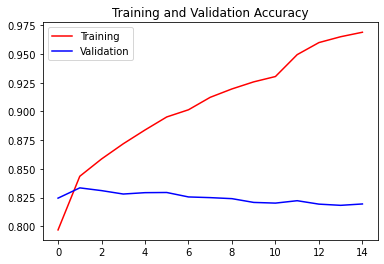

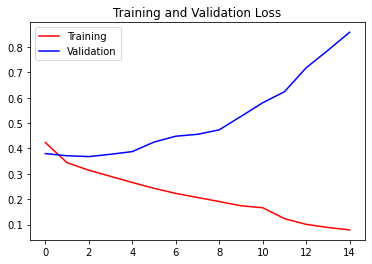

<Figure size 432x288 with 0 Axes>

In [29]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Sarcasm - Conv1D

In [30]:
NUM_CLASSES = 1

In [31]:
model = Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(24, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           16000     
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
__________________________________________________

In [33]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [34]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [35]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=12)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=8, min_lr=0.001, mode='min', verbose=1, factor=0.1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [36]:
EPOCHS = 20
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [37]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/20
625/625 [==============================] - 6s 8ms/step - loss: 0.4442 - accuracy: 0.7860 - val_loss: 0.4051 - val_accuracy: 0.8138 - lr: 0.0100
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 0.3611 - accuracy: 0.8375 - val_loss: 0.3974 - val_accuracy: 0.8164 - lr: 0.0100
Epoch 3/20
625/625 [==============================] - 5s 7ms/step - loss: 0.3174 - accuracy: 0.8568 - val_loss: 0.3892 - val_accuracy: 0.8208 - lr: 0.0100
Epoch 4/20
625/625 [==============================] - 5s 7ms/step - loss: 0.2833 - accuracy: 0.8756 - val_loss: 0.4243 - val_accuracy: 0.8091 - lr: 0.0100
Epoch 5/20
625/625 [==============================] - 5s 7ms/step - loss: 0.2439 - accuracy: 0.8952 - val_loss: 0.4527 - val_accuracy: 0.8079 - lr: 0.0100
Epoch 6/20
625/625 [==============================] - 5s 7ms/step - loss: 0.2136 - accuracy: 0.9091 - val_loss: 0.5063 - val_accuracy: 0.8120 - lr: 0.0100
Epoch 7/20
625/625 [==============================] - 5s 7ms/step - lo

<Figure size 432x288 with 0 Axes>

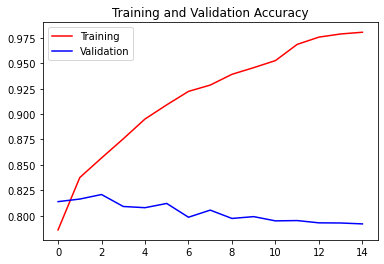

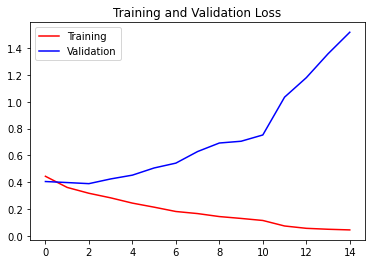

<Figure size 432x288 with 0 Axes>

In [38]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

## Exercise 11

Running on Stanford dataset.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
import pandas as pd
import numpy as np
import csv
import random
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /content/training_cleaned.csv

--2021-10-17 14:19:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/content/training_cleaned.csv’

/content/training_c 100%[===================>] 227.87M   155MB/s    in 1.5s    

2021-10-17 14:19:49 (155 MB/s) - ‘/content/training_cleaned.csv’ saved [238942690/238942690]



In [ ]:
num_sentences = 0
corpus = []

with open("/content/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [ ]:
num_sentences

1600000

In [ ]:
len(corpus)

1600000

In [ ]:
corpus[:2]

[["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
  0],
 ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
  0]]

In [ ]:
embedding_dim = 100                         # number of dimensions we wish to embed each word into
max_length = 16                             # maximum length of document/sentence

trunc_type = "post"                     
padding_type = "post"
oov_tok = "<OOV>"                           # out of vocab words in test set will be marked OOV
training_size = 160000                      # only considering first 1.6L records to be in scope
test_portion = 0.1                          # 10% records out of 1.6L churned data will be test set

In [ ]:
sentences = []
labels = []

random.shuffle(corpus)

for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

In [ ]:
sentences[:5]

['Bonnaroo was a blast. But I missed so many bands ',
 "Top 'o the morning to you! Have a safe and beautiful day. ",
 "I've finished all law exams - period!!! This deserves more exclamation marks. !!!! Wasn't the greatest exam I've done though ",
 'No time for revisions tonight. Just too tired.  but the question is... whoisjimmystone.com ??? ;)',
 'AAAAHHHHHHHHH! Tmr they having some sort of Sims gathering at Iluma. If only I could go. ']

In [ ]:
labels[:5]

[0, 1, 0, 0, 0]

In [ ]:
split = int(test_portion * training_size)

training_sentences = sentences[split:training_size]           # 16k-th record to 1.6L-th record is train data
training_labels = labels[split:training_size]

testing_sentences = sentences[:split]                         # first 16k records is test data
testing_labels = labels[:split]

In [ ]:
len(training_sentences), len(training_labels), len(testing_sentences), len(testing_labels)

(144000, 144000, 16000, 16000)

In [ ]:
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
training_padded[:2]

array([[22791,     2,  3234,   842,   583,   161,     2,  1801,    18,
           14,   282,   118,    23,    35,    27,   417],
       [  115,     2,    67,     6, 36519,   206,    72,   133,   362,
            0,     0,     0,     0,     0,     0,     0]], dtype=int32)

In [ ]:
testing_sequences[:2]

[[7320, 26, 5, 1374, 19, 2, 270, 16, 320, 2630],
 [678, 43984, 4, 97, 3, 8, 17, 5, 948, 7, 345, 31]]

In [ ]:
training_labels[:2]

[1, 0]

In [ ]:
testing_labels[:2]

[0, 1]

In [ ]:
vocab_size

128793

In [ ]:
word_index['hi']

317

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
# getting Glove

!wget 'http://nlp.stanford.edu/data/glove.6B.zip'

--2021-10-17 14:47:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-10-17 14:47:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-17 14:47:48--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip '/content/glove.6B.zip'

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       y



In [ ]:
import os

embeddings_index = {}
GLOVE_DIR = '/content/'

f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [ ]:
len(embeddings_matrix)

128794

In [ ]:
embeddings_matrix[5]

array([-0.27085999,  0.044006  , -0.02026   , -0.17395   ,  0.6444    ,
        0.71213001,  0.35510001,  0.47138   , -0.29637   ,  0.54426998,
       -0.72294003, -0.0047612 ,  0.040611  ,  0.043236  ,  0.29729   ,
        0.10725   ,  0.40156001, -0.53662002,  0.033382  ,  0.067396  ,
        0.64556003, -0.085523  ,  0.14103   ,  0.094539  ,  0.74947   ,
       -0.19400001, -0.68739003, -0.41740999, -0.22807001,  0.12      ,
       -0.48999   ,  0.80944997,  0.045138  , -0.11898   ,  0.20161   ,
        0.39276001, -0.20121001,  0.31354001,  0.75304002,  0.25907001,
       -0.11566   , -0.029319  ,  0.93498999, -0.36067   ,  0.52420002,
        0.23706   ,  0.52714998,  0.22869   , -0.51958001, -0.79348999,
       -0.20367999, -0.50186998,  0.18748   ,  0.94282001, -0.44834   ,
       -3.67919993,  0.044183  , -0.26751   ,  2.19970012,  0.241     ,
       -0.033425  ,  0.69553   , -0.64472002, -0.0072277 ,  0.89574999,
        0.20015   ,  0.46493   ,  0.61932999, -0.1066    ,  0.08

In [ ]:
len(embeddings_matrix[5])

100

In [ ]:
num_classes = 1

In [ ]:
model = Sequential([
    layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    layers.Dropout(0.2),
    layers.Conv1D(64, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=4),
    layers.LSTM(64),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           12879400  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,944,553
Trainable params: 65,153
Non-trainable params: 12,879,400
_______________________________________

In [ ]:
optimizer   = tf.keras.optimizers.Adam(learning_rate=0.01)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
early_stopping    = EarlyStopping(monitor='loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
epochs = 40
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(training_padded,
                    training_labels,
                    validation_data=(testing_padded, testing_labels),
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/40
4500/4500 [==============================] - 31s 5ms/step - loss: 0.5955 - accuracy: 0.6763 - val_loss: 0.5708 - val_accuracy: 0.6977
Epoch 2/40
4500/4500 [==============================] - 22s 5ms/step - loss: 0.5765 - accuracy: 0.6928 - val_loss: 0.5546 - val_accuracy: 0.7087
Epoch 3/40
4500/4500 [==============================] - 22s 5ms/step - loss: 0.5749 - accuracy: 0.6942 - val_loss: 0.5636 - val_accuracy: 0.7014
Epoch 4/40
4500/4500 [==============================] - 22s 5ms/step - loss: 0.5749 - accuracy: 0.6932 - val_loss: 0.5578 - val_accuracy: 0.7083
Epoch 5/40
4500/4500 [==============================] - 22s 5ms/step - loss: 0.5736 - accuracy: 0.6951 - val_loss: 0.5617 - val_accuracy: 0.7061
Epoch 6/40
4500/4500 [==============================] - 22s 5ms/step - loss: 0.5749 - accuracy: 0.6952 - val_loss: 0.5690 - val_accuracy: 0.7028
Epoch 7/40
4500/4500 [==============================] - 22s 5ms/step - loss: 0.5715 - accuracy: 0.6974 - val_loss: 0.5616 - val_ac

<Figure size 432x288 with 0 Axes>

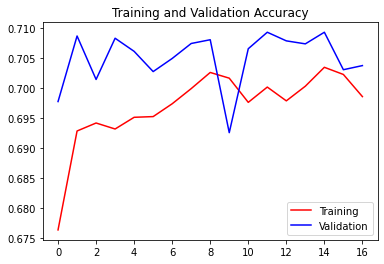

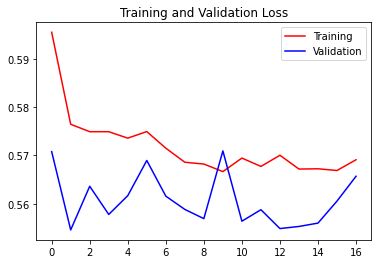

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()